In [1]:
#| echo: false

# Import Pandas, Seaborn, and related
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('paper')

## Dataset Overview

The dataset contains **79 explanatory variables** describing different aspects of residential homes in Ames, Iowa.  
Key fields include:

- `SalePrice`: the target variable representing the sale price of the house.
- `MSSubClass`: building class.
- `MSZoning`: general zoning classification.
- `LotFrontage`: linear feet of street connected to the property.
- `OverallQual`: overall material and finish quality.
- `GrLivArea`: above ground living area (in square feet).
- ...

The training set contains 1,460 observations with 81 columns (including `SalePrice`), while the test set contains 1,459 observations with 80 columns (missing `SalePrice`).  

We aim to predict `SalePrice` for the test set and evaluate models using Root Mean Squared Error (RMSE) on the log-transformed prices (as per the competition’s metric).


In [2]:
# Load the training and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Display the first few rows of the training data and basic info
print('Training data shape:', train_df.shape)
print('Test data shape:', test_df.shape)
train_df.head()

Training data shape: (1460, 81)
Test data shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Exploratory Data Analysis

Before building models, we explore the distribution of the target variable and some important features.  
A look at the sale price distribution reveals skewness, which suggests a log transformation will be beneficial for regression models.

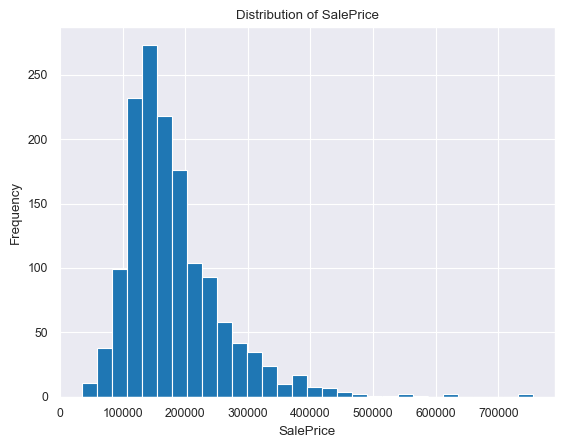

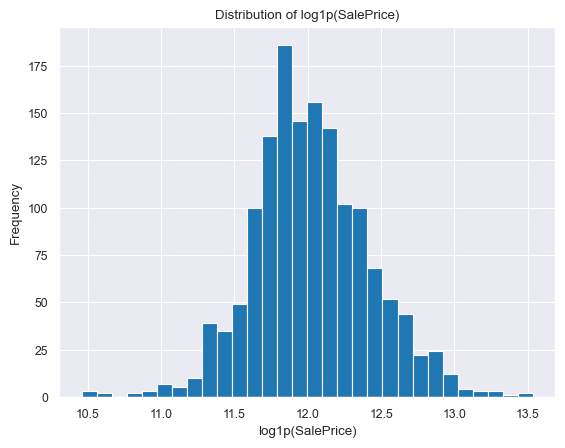

In [3]:
# Plot the distribution of the target variable SalePrice
plt.figure()
plt.hist(train_df['SalePrice'], bins=30)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

# Log-transformed SalePrice distribution
plt.figure()
plt.hist(np.log1p(train_df['SalePrice']), bins=30)
plt.title('Distribution of log1p(SalePrice)')
plt.xlabel('log1p(SalePrice)')
plt.ylabel('Frequency')
plt.show()

### SalePrice vs. Overall Quality

House quality (`OverallQual`) is one of the most influential features.  
Below we display a boxplot and a violin plot of `SalePrice` by `OverallQual` to visualize how sale prices vary across quality levels.


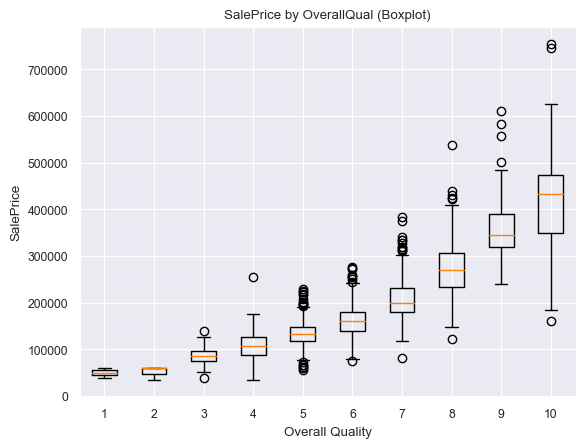

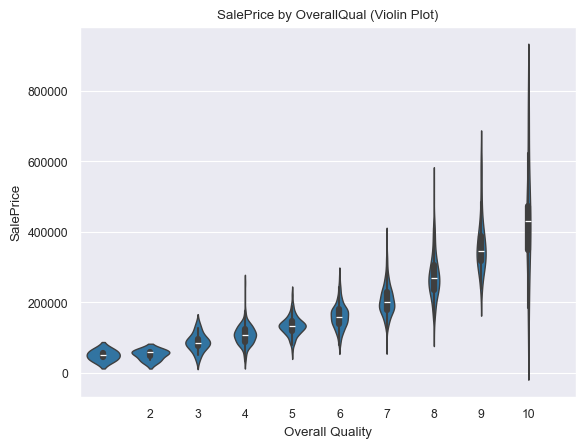

In [6]:
# Create boxplot of SalePrice by OverallQual
plt.figure()
# Prepare data groups for each quality level
qualities = sorted(train_df['OverallQual'].unique())
boxes = [train_df[train_df['OverallQual'] == q]['SalePrice'] for q in qualities]
plt.boxplot(boxes, labels=qualities)
plt.title('SalePrice by OverallQual (Boxplot)')
plt.xlabel('Overall Quality')
plt.ylabel('SalePrice')
plt.show()

# Violin plot use sns on boxes
import seaborn as sns
plt.figure()
sns.violinplot(x='OverallQual', y='SalePrice', data=train_df)
plt.title('SalePrice by OverallQual (Violin Plot)')
plt.xlabel('Overall Quality')
plt.ylabel('SalePrice')
plt.xticks(qualities)
plt.show()

### Living Area vs. SalePrice

A scatter plot helps illustrate the relationship between the above-ground living area (`GrLivArea`) and the sale price.  
We expect larger homes to sell for higher prices, albeit with some variability.


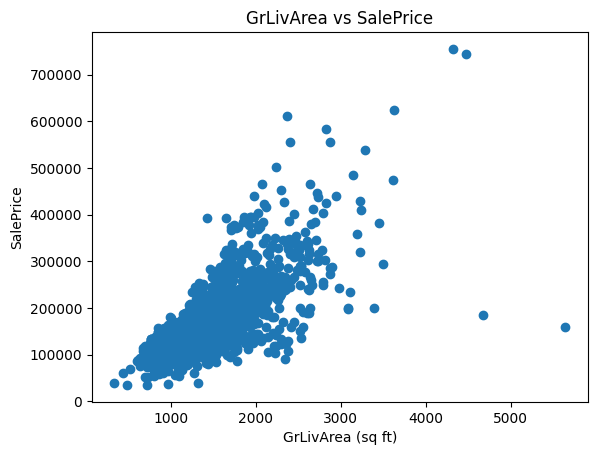

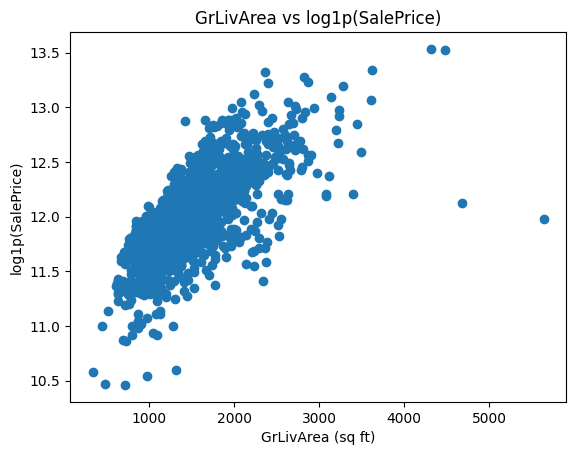

In [4]:

# Scatter plot of GrLivArea vs SalePrice
plt.figure()
plt.scatter(train_df['GrLivArea'], train_df['SalePrice'])
plt.title('GrLivArea vs SalePrice')
plt.xlabel('GrLivArea (sq ft)')
plt.ylabel('SalePrice')
plt.show()

# Scatter plot of GrLivArea vs log1p(SalePrice)
plt.figure()
plt.scatter(train_df['GrLivArea'], np.log1p(train_df['SalePrice']))
plt.title('GrLivArea vs log1p(SalePrice)')
plt.xlabel('GrLivArea (sq ft)')
plt.ylabel('log1p(SalePrice)')
plt.show()


### Correlation Matrix

Understanding feature correlations with `SalePrice` can guide feature engineering and model selection.  
The heatmap below displays the correlation between the sale price and the top 10 numerical features most strongly correlated with it.


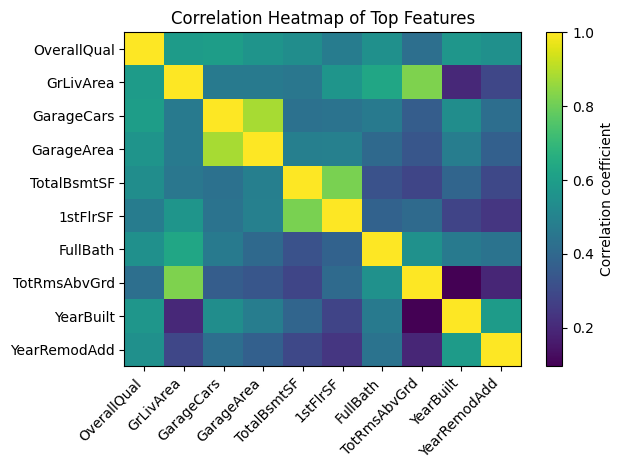

In [5]:

# Compute the correlation matrix for numeric features
numeric_df = train_df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

# Get the 10 features most correlated with SalePrice (excluding SalePrice itself)
top_corr = corr['SalePrice'].abs().sort_values(ascending=False).head(11)
top_features = top_corr.index.tolist()
top_features.remove('SalePrice')

# Sub-correlation matrix for top features
sub_corr = corr.loc[top_features, top_features]

# Plot heatmap
plt.figure()
plt.imshow(sub_corr, aspect='auto')
plt.colorbar(label='Correlation coefficient')
plt.xticks(range(len(top_features)), top_features, rotation=45, ha='right')
plt.yticks(range(len(top_features)), top_features)
plt.title('Correlation Heatmap of Top Features')
plt.tight_layout()
plt.show()

### Missing Values

Missing data can adversely affect model performance. We count missing values for each feature and visualize the top 20 features with the highest number of missing values.


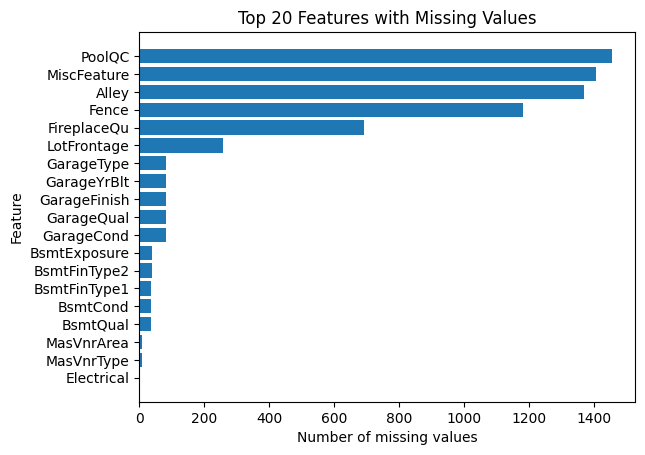

In [6]:
# Count missing values per feature
missing_counts = train_df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

# Plot the top 20 features with missing values
top_missing = missing_counts.head(20)
plt.figure()
plt.barh(top_missing.index, top_missing.values)
plt.xlabel('Number of missing values')
plt.ylabel('Feature')
plt.title('Top 20 Features with Missing Values')
plt.gca().invert_yaxis()  # Highest missing values on top
plt.show()

### EDA Summary

- **SalePrice distribution:** The sale price distribution is right-skewed; using the logarithm of the sale price produces a more symmetrical distribution, which is more suitable for regression.  
- **Overall quality:** Both boxplots and violin plots show that houses with higher overall quality have higher median sale prices and wider price ranges.  
- **Living area:** There is a strong positive relationship between above-ground living area (`GrLivArea`) and sale price; log-transforming the target still shows a positive trend.  
- **Correlation heatmap:** Features like `OverallQual`, `GrLivArea`, `GarageArea`, and `TotalBsmtSF` are among the most correlated with the sale price.  
- **Missing values:** Some features have substantial missing data (e.g., `PoolQC`, `MiscFeature`); appropriate imputation strategies are necessary during preprocessing.


## Data Preprocessing and Modeling

We will prepare the data for machine learning by handling missing values, encoding categorical variables, and scaling numeric variables.  

We will compare several regression models:

1. **Linear Regression (baseline).**
2. **Random Forest Regressor.**
3. **Gradient Boosting Regressor.**
4. **K-Nearest Neighbors (KNN) Regressor.**
5. **Support Vector Regressor (SVR).**
6. **Multilayer Perceptron (MLP) Regressor (neural network).**

To illustrate another tool, we will also load the dataset into a SQLite database and run a simple SQL query.


In [8]:
import sqlite3

# Create a SQLite database and save the training data
conn = sqlite3.connect('housing.db')
train_df.to_sql('houses', conn, if_exists='replace', index=False)

# Example SQL query: average sale price by neighborhood (top 10)
query = '''
SELECT Neighborhood, AVG(SalePrice) as AvgPrice
FROM houses
GROUP BY Neighborhood
ORDER BY AvgPrice DESC
LIMIT 10
'''

avg_prices = pd.read_sql_query(query, conn)
print('Top 10 neighborhoods by average sale price:')
print(avg_prices)

# Close the connection
conn.close()

Top 10 neighborhoods by average sale price:
  Neighborhood       AvgPrice
0      NoRidge  335295.317073
1      NridgHt  316270.623377
2      StoneBr  310499.000000
3       Timber  242247.447368
4      Veenker  238772.727273
5      Somerst  225379.837209
6      ClearCr  212565.428571
7      Crawfor  210624.725490
8      CollgCr  197965.773333
9      Blmngtn  194870.882353


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Separate features and target
X = train_df.drop(columns=['SalePrice'])
y = train_df['SalePrice']

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numeric and categorical columns
numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns

# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define models to compare
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200),
    'GradientBoosting': GradientBoostingRegressor(),
    'KNeighbors': KNeighborsRegressor(n_neighbors=5),
    'SVR': SVR(C=100, gamma=0.1),
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500)
}

results = []

for name, reg in models.items():
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', reg)
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    score = np.sqrt(mean_squared_error(y_pred, y_val))
    results.append((name, score))
    print(f"{name}: RMSE = {score:.4f}")

# Convert results to DataFrame for display
results_df = pd.DataFrame(results, columns=['Model', 'RMSE']).sort_values(by='RMSE')
results_df

LinearRegression: RMSE = 29475.2826
RandomForest: RMSE = 28713.9454
GradientBoosting: RMSE = 26844.7583
KNeighbors: RMSE = 38826.9257
SVR: RMSE = 88527.1376
MLPRegressor: RMSE = 33864.5930


C:\Users\cxy\anaconda3\envs\tmpsb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,RMSE
2,GradientBoosting,26844.758262
1,RandomForest,28713.945394
0,LinearRegression,29475.282613
5,MLPRegressor,33864.592998
3,KNeighbors,38826.925732
4,SVR,88527.137551


### Model Performance Comparison

The following bar chart summarizes the root mean squared error (RMSE) on the logarithm of the sale price for each model on the validation set. Lower values indicate better performance.

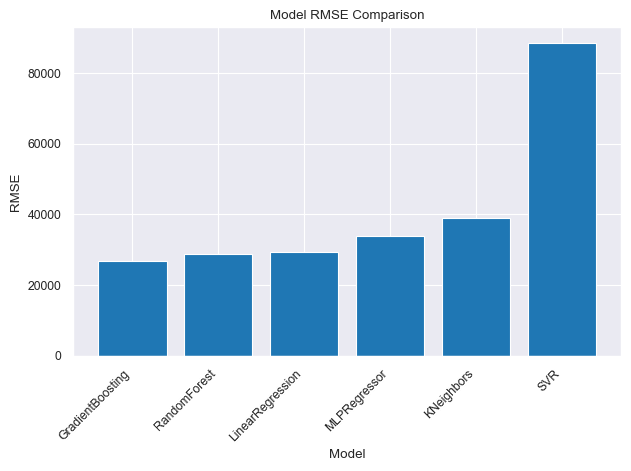

In [11]:
# Plot model performance
plt.figure()
plt.bar(results_df['Model'], results_df['RMSE'])
plt.title('Model RMSE Comparison')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Training the Best Model and Generating Predictions

From the comparison above, we identify the model with the lowest RMSE is Gradient Boosting Regressor.
We use a auto-progress to select the optimal model, and train this model on the entire training dataset and generate predictions for the test set.  
Finally, we will create a submission file that can be uploaded to Kaggle.

In [13]:
# Select the best model based on validation performance
best_model_name = results_df.iloc[0]['Model']
print(f"Best model selected: {best_model_name}")

# Mapping between model names and regressor instances
regressor_mapping = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'KNeighbors': KNeighborsRegressor(n_neighbors=5),
    'SVR': SVR(C=100, gamma=0.1),
    'MLPRegressor': MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500, random_state=42)
}

# Build pipeline with the selected regressor
best_regressor = regressor_mapping[best_model_name]
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_regressor)
])

# Fit on the full training data using log-transformed target
best_pipeline.fit(X, np.log1p(y))

# Predict on the test data
preds_log = best_pipeline.predict(test_df)
preds = np.expm1(preds_log)  # invert log transformation

# Create submission DataFrame
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': preds
})

# Save submission file
submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)
print('Submission file saved to:', submission_path)

submission.head()

Best model selected: GradientBoosting
Submission file saved to: submission.csv


,Id,SalePrice
0,1461,123457.195831
1,1462,152359.231361
2,1463,183532.030671
3,1464,188338.391828
4,1465,192985.901170


## Conclusion

In this project we performed an end-to-end data science workflow on the Ames Housing dataset.  
Key takeaways include:

- Data visualization revealed skewness in the target variable and highlighted the importance of features like overall quality and living area.
- Preprocessing steps such as handling missing values, encoding categorical variables, and scaling were crucial for model performance.
- Comparing multiple models showed that simple models and ensemble models performed competitively on the target, while more complex models like neural networks did not necessarily offer significant improvement with the chosen hyperparameters.
- SQL integration demonstrated how to load the dataset into a database and run queries for additional insights (e.g., average sale price per neighborhood).
- The best-performing model was trained on the full dataset and used to generate predictions for the test set, resulting in a ready-to-upload Kaggle submission file.

Further improvements could include hyperparameter tuning, experimenting with additional models like XGBoost or LightGBM, and more advanced feature engineering.  
Nonetheless, this notebook provides a solid foundation for approaching the Kaggle House Prices competition and demonstrates the use of multiple tools and techniques in a single, coherent workflow.